Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

Understanding the Dataset

In [4]:
data=pd.read_csv('cart_abandonment_dataset.csv')
data.head()

,User_ID,User_Location,Gender,Cart_Contents,Cart_Value,Session_Date,Session_Duration,Abandonment_Reason,Purchase_Category,Referral_Medium,Device_Type,Cart_Status
0,User_1,Virginia,Male,Toys,152.01,12/24/2023,99,NaN,Teddy bears,Email,Tablet,Paid
1,User_2,Florida,Male,Footwear,222.52,10/3/2023,32,NaN,Oxfords,Social Media,Tablet,Paid
2,User_3,New York,Male,Toys,331.94,11/19/2023,62,Complex Checkout,Games,Social Media,Desktop,Abandoned
3,User_4,Virginia,Male,Toys,222.85,12/2/2023,32,NaN,Dolls,Search Engine,Mobile,Paid
4,User_5,Chicago,Female,Home Decor,309.79,8/2/2023,63,No Total Order Upfront,Vase,Social Media,Mobile,Abandoned


In [5]:
data.shape

(7211, 12)

In [6]:
#Understanding Data Types of Different Columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7211 entries, 0 to 7210
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   User_ID             7211 non-null   object 
 1   User_Location       7211 non-null   object 
 2   Gender              7211 non-null   object 
 3   Cart_Contents       7211 non-null   object 
 4   Cart_Value          7211 non-null   float64
 5   Session_Date        7211 non-null   object 
 6   Session_Duration    7211 non-null   int64  
 7   Abandonment_Reason  3447 non-null   object 
 8   Purchase_Category   7211 non-null   object 
 9   Referral_Medium     7211 non-null   object 
 10  Device_Type         7211 non-null   object 
 11  Cart_Status         7211 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 676.2+ KB


Data Cleaning

In [7]:
#Checking Null Values
data.isna().sum()

,0
User_ID,0
User_Location,0
Gender,0
Cart_Contents,0
Cart_Value,0
Session_Date,0
Session_Duration,0
Abandonment_Reason,3764
Purchase_Category,0
Referral_Medium,0


In [8]:
data['Abandonment_Reason'].unique()

array([nan, 'Complex Checkout', 'No Total Order Upfront',
       'No Guest Checkout Option', 'Shipping Cost'], dtype=object)

In [9]:
#Filling NaN Values
data['Abandonment_Reason'].fillna('Paid', inplace=True)
data.isna().sum()

,0
User_ID,0
User_Location,0
Gender,0
Cart_Contents,0
Cart_Value,0
Session_Date,0
Session_Duration,0
Abandonment_Reason,0
Purchase_Category,0
Referral_Medium,0


In [10]:
#Checking Outliers
data.describe()

,Cart_Value,Session_Duration
count,7211.000000,7211.000000
mean,258.364550,62.097213
std,138.298901,33.431610
min,20.040000,5.000000
25%,138.275000,33.000000
50%,257.960000,62.000000
75%,379.360000,91.000000
max,499.910000,120.000000


In [11]:
#Checking Duplicate Values
data.duplicated().sum()

np.int64(0)

Feature Engineering

In [12]:
#Dividing Session_Date into Date, Month, Year
data['Session_Date']=pd.to_datetime(data['Session_Date'])
data['Day']=data['Session_Date'].dt.day_name()
data['Year']=data['Session_Date'].dt.year
data['Month']=data['Session_Date'].dt.month
data['Date']=data['Session_Date'].dt.day
data['Week']=data['Session_Date'].dt.isocalendar().week
data.drop(['Session_Date'], axis=1, inplace=True)
data.head()

,User_ID,User_Location,Gender,Cart_Contents,Cart_Value,Session_Duration,Abandonment_Reason,Purchase_Category,Referral_Medium,Device_Type,Cart_Status,Day,Year,Month,Date,Week
0,User_1,Virginia,Male,Toys,152.01,99,Paid,Teddy bears,Email,Tablet,Paid,Sunday,2023,12,24,51
1,User_2,Florida,Male,Footwear,222.52,32,Paid,Oxfords,Social Media,Tablet,Paid,Tuesday,2023,10,3,40
2,User_3,New York,Male,Toys,331.94,62,Complex Checkout,Games,Social Media,Desktop,Abandoned,Sunday,2023,11,19,46
3,User_4,Virginia,Male,Toys,222.85,32,Paid,Dolls,Search Engine,Mobile,Paid,Saturday,2023,12,2,48
4,User_5,Chicago,Female,Home Decor,309.79,63,No Total Order Upfront,Vase,Social Media,Mobile,Abandoned,Wednesday,2023,8,2,31


In [13]:
data.columns

Index(['User_ID', 'User_Location', 'Gender', 'Cart_Contents', 'Cart_Value',
       'Session_Duration', 'Abandonment_Reason', 'Purchase_Category',
       'Referral_Medium', 'Device_Type', 'Cart_Status', 'Day', 'Year', 'Month',
       'Date', 'Week'],
      dtype='object')

In [14]:
#Checking the Number of Unique Values in Each Column
for col in data.columns:
  print(f'{col}:{data[col].nunique()}')

User_ID:7211
User_Location:6
Gender:2
Cart_Contents:6
Cart_Value:6718
Session_Duration:116
Abandonment_Reason:5
Purchase_Category:25
Referral_Medium:3
Device_Type:3
Cart_Status:2
Day:7
Year:1
Month:5
Date:31
Week:22


Exploratory Data Analysis

In [15]:
#Checking if the Data is Balanced
print(data['Cart_Status'].value_counts())

Cart_Status
Paid         3764
Abandoned    3447
Name: count, dtype: int64


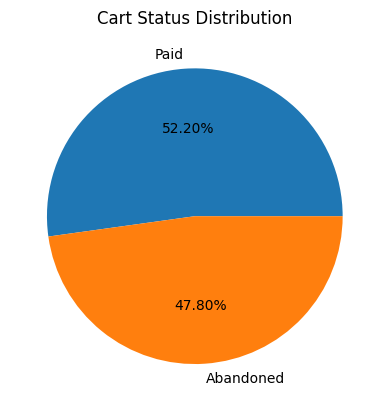

In [16]:
#Plotting a Chart of Cart Status Distribution
plt.pie(data['Cart_Status'].value_counts(), labels=data['Cart_Status'].value_counts().index, autopct='%1.2f%%')
plt.title('Cart Status Distribution')
plt.show()

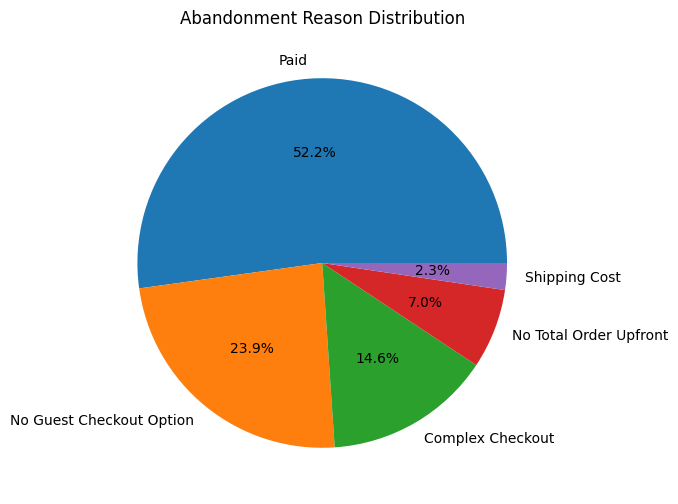

In [17]:
#Plotting a Chart of Abandonment Reason Distribution
plt.figure(figsize=(12, 6))
plt.pie(data['Abandonment_Reason'].value_counts(), labels=data['Abandonment_Reason'].value_counts().index, autopct='%1.1f%%')
plt.title('Abandonment Reason Distribution')
plt.show()

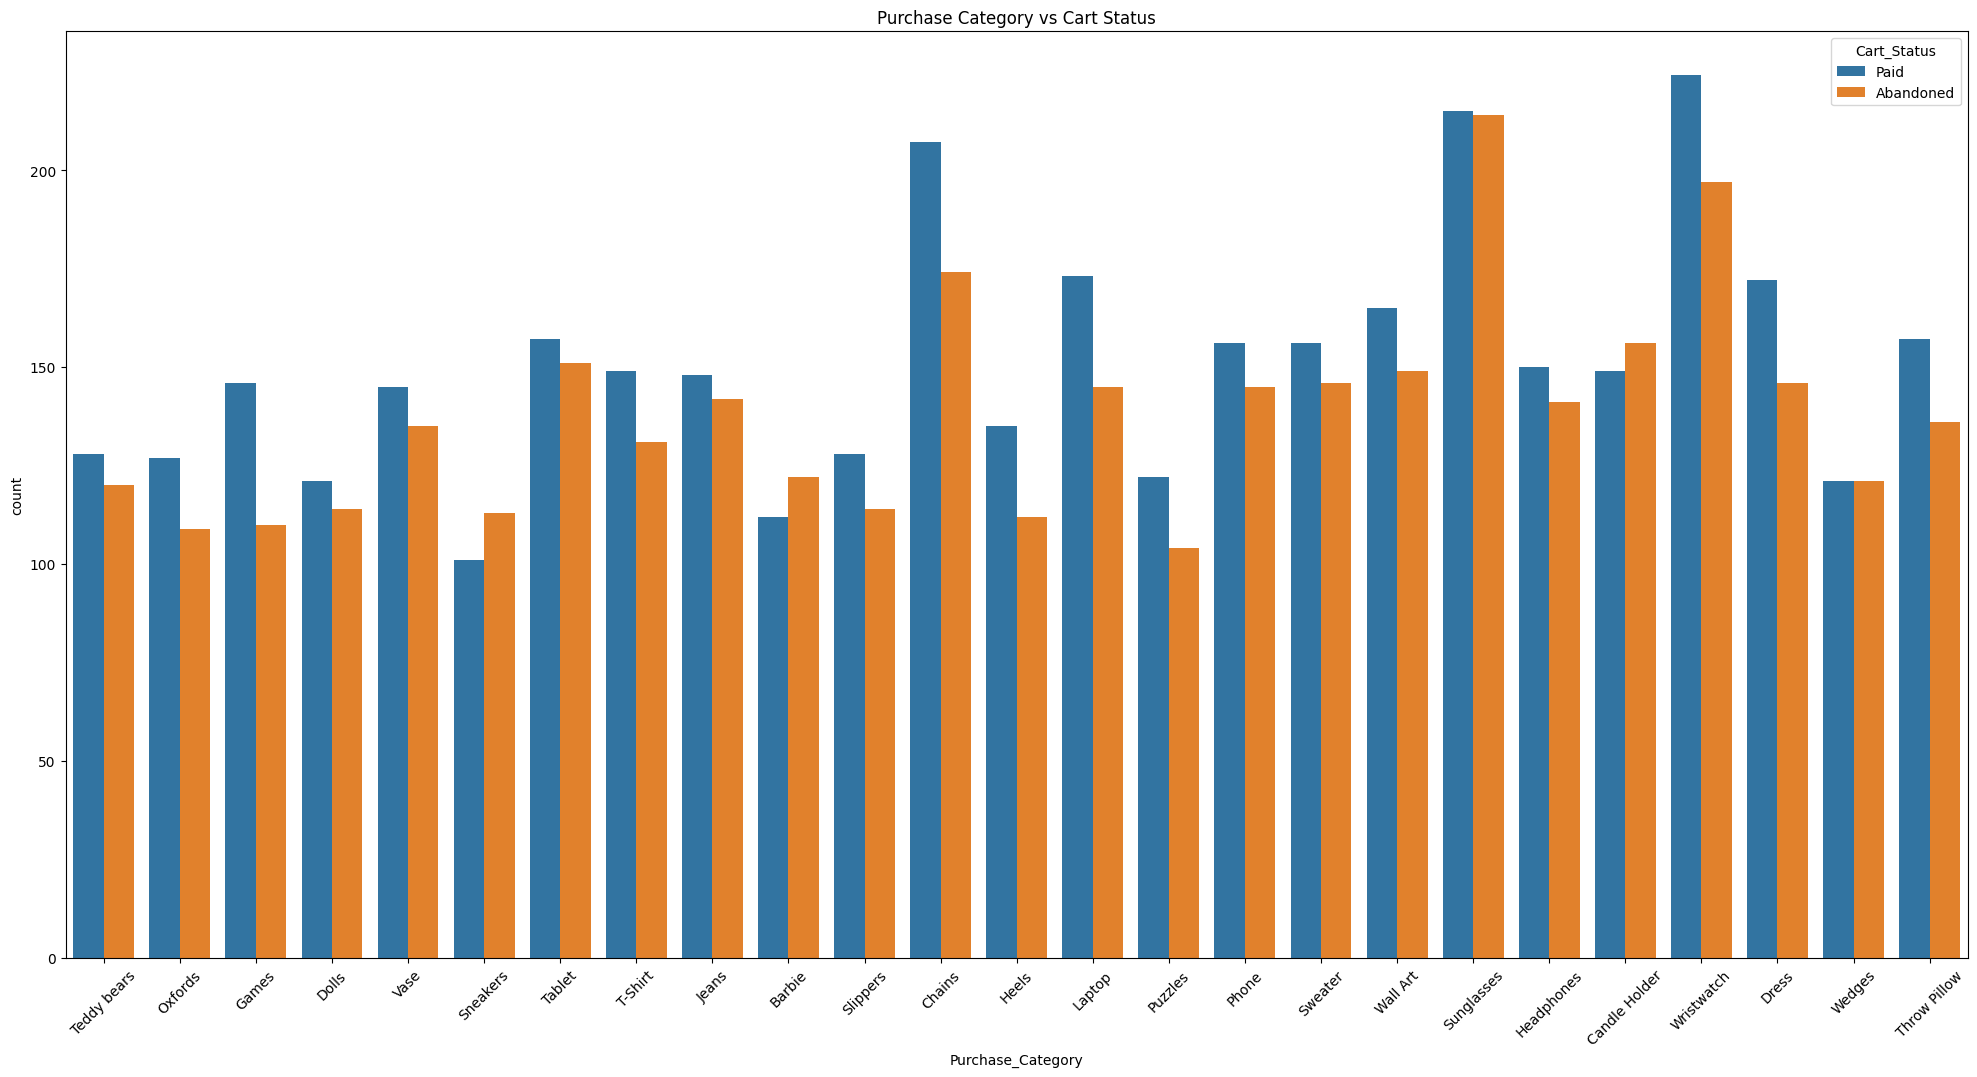

In [18]:
#Plotting a Chart of Purchase Category vs Cart Status
plt.figure(figsize=(20, 10))
sns.countplot(data=data, x='Purchase_Category', hue='Cart_Status')
plt.tight_layout()
plt.xticks(rotation=45)
plt.title('Purchase Category vs Cart Status')
plt.show()

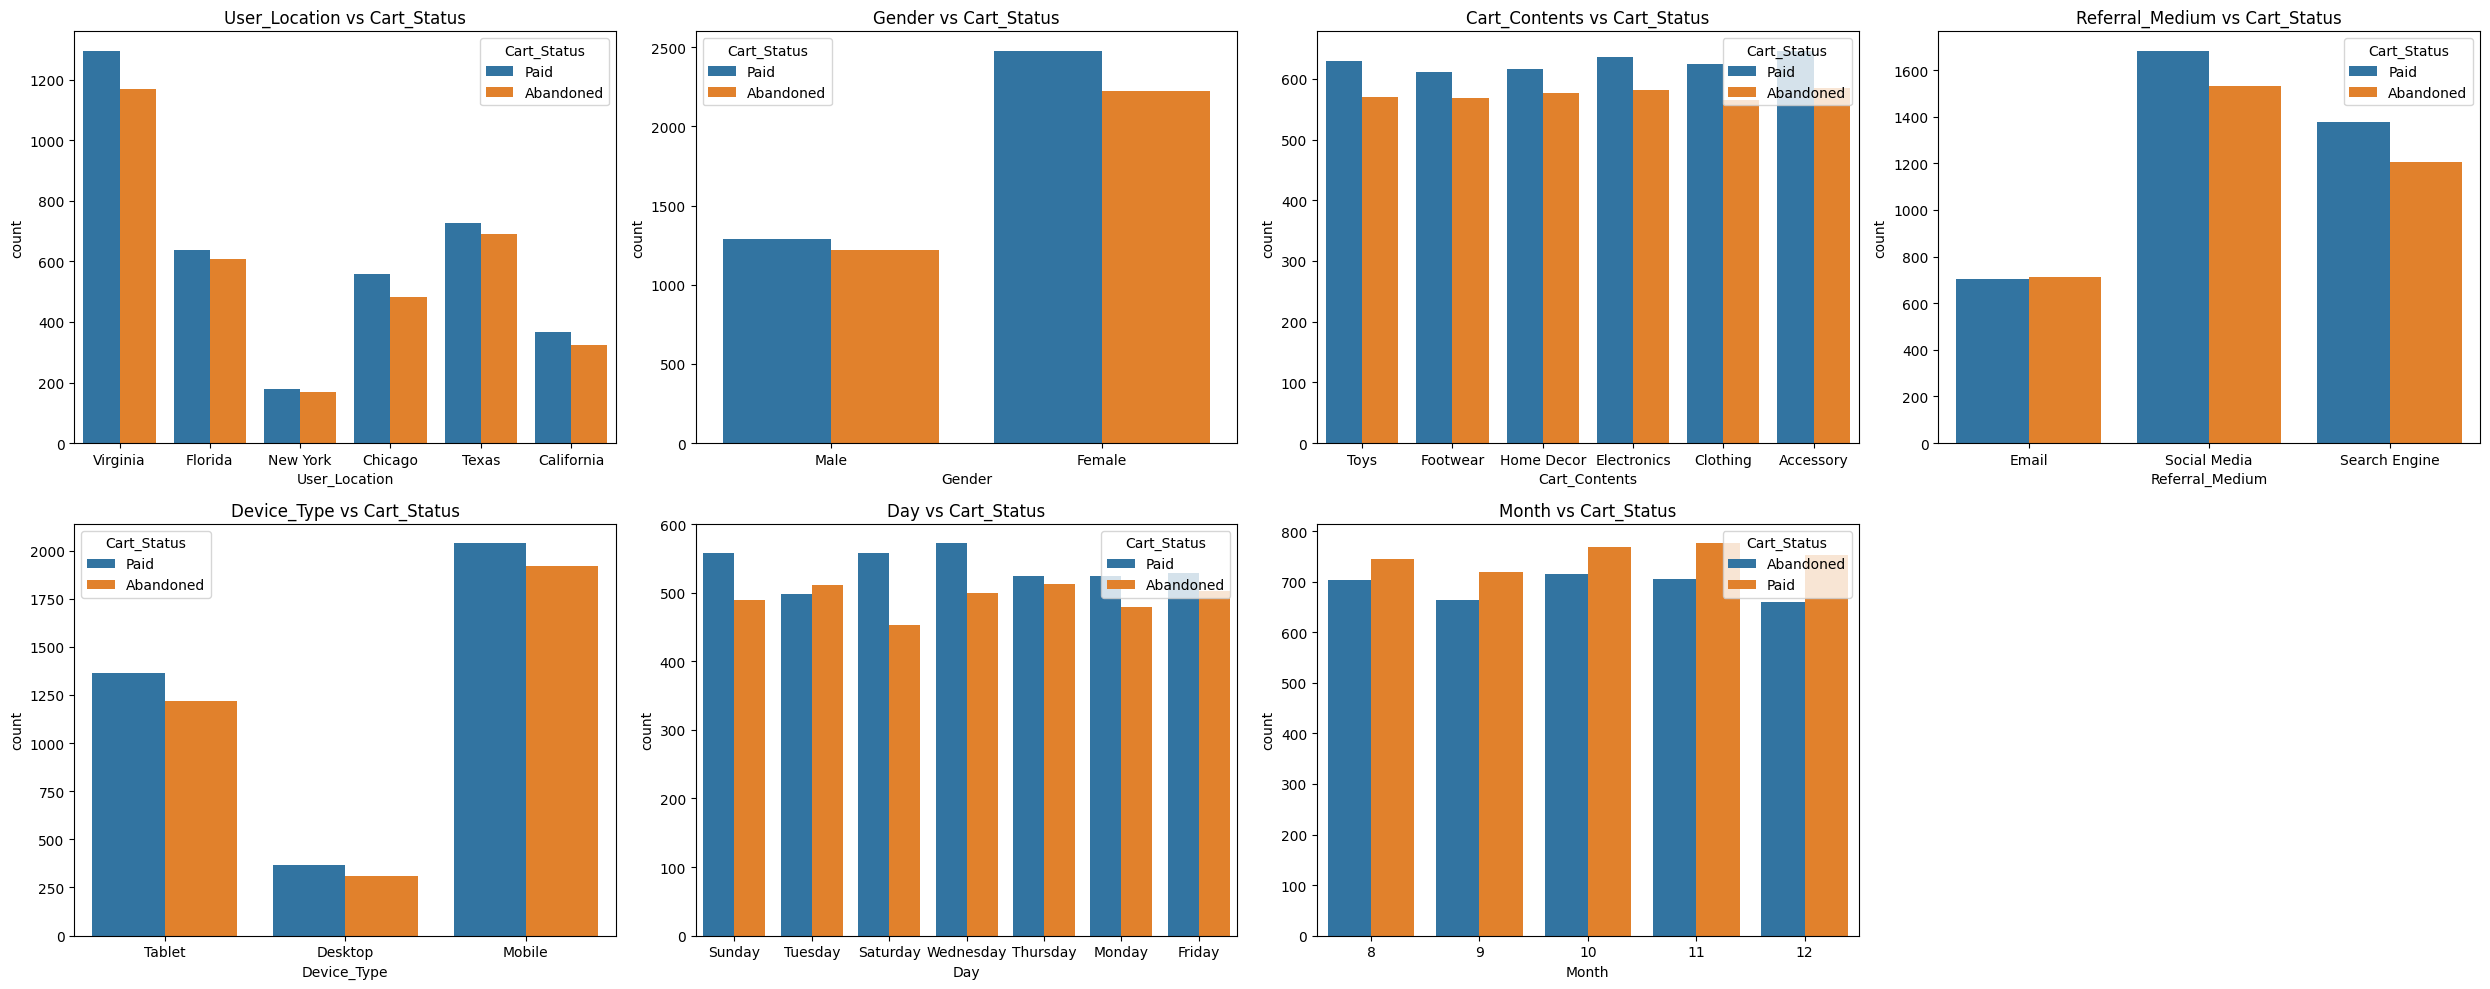

In [19]:
#Plotting Charts of Different Columns against Cart Status
columns=['User_Location', 'Gender', 'Cart_Contents', 'Referral_Medium', 'Device_Type', 'Day', 'Month']

plt.figure(figsize=(25, 10))
for col in columns:
  plt.subplot(2, 4, columns.index(col)+1)
  sns.countplot(data=data, x=col, hue='Cart_Status')
  plt.title(f'{col} vs Cart_Status')
  plt.tight_layout()
plt.show()

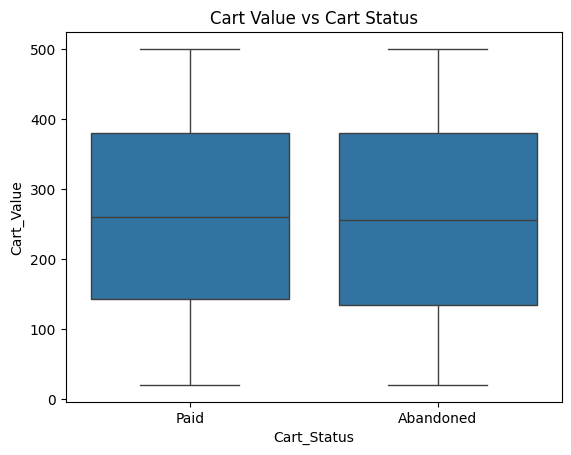

In [20]:
#Plotting a Chart of Cart Value vs Cart Status
sns.boxplot(x='Cart_Status', y='Cart_Value', data=data)
plt.title('Cart Value vs Cart Status')
plt.show()

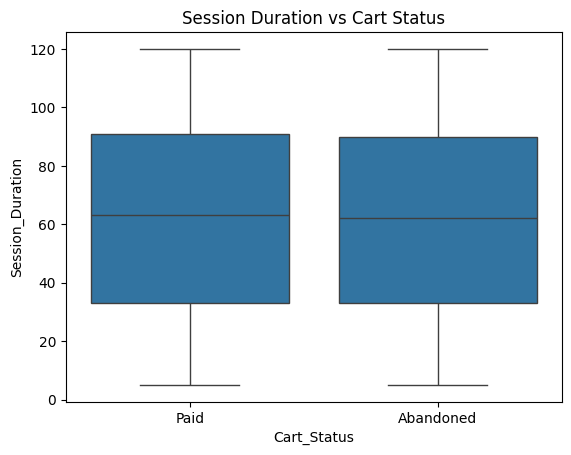

In [21]:
#Plotting a Chart of Session Duration vs Cart Status
sns.boxplot(x='Cart_Status', y='Session_Duration', data=data)
plt.title('Session Duration vs Cart Status')
plt.show()

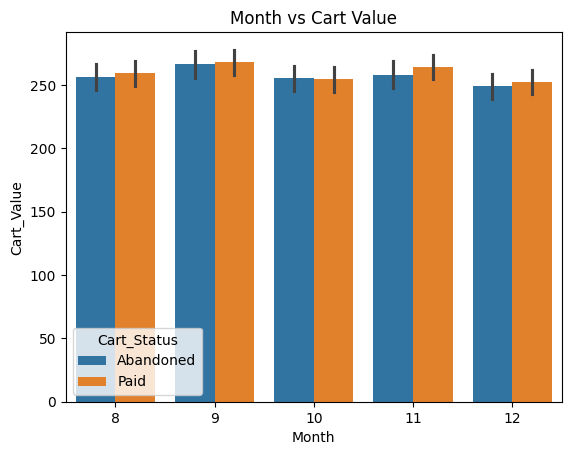

In [22]:
#Plotting a Chart of Month vs Cart Value
sns.barplot(x='Month', y='Cart_Value', hue='Cart_Status', data=data)
plt.title('Month vs Cart Value')
plt.show()

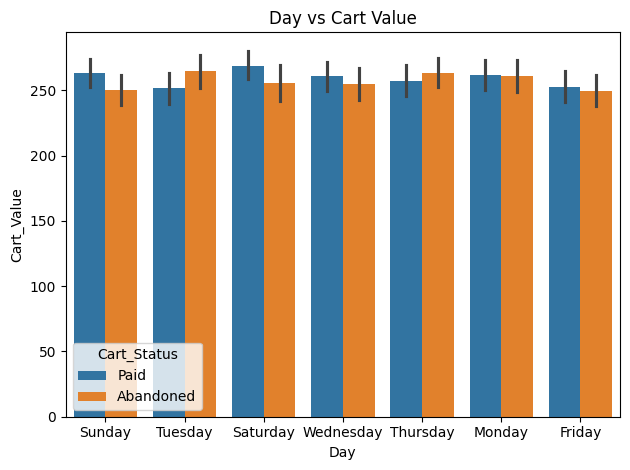

In [23]:
##Plotting a Chart of Day vs Cart Value
sns.barplot(x='Day', y='Cart_Value', hue='Cart_Status', data=data)
plt.title('Day vs Cart Value')
plt.tight_layout()
plt.show()

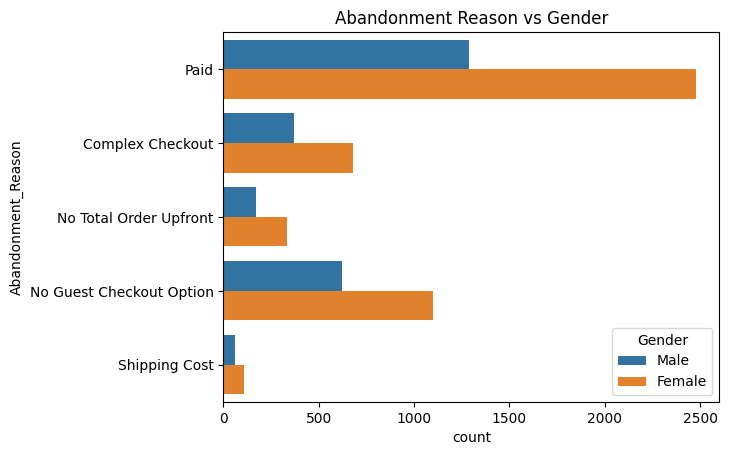

In [24]:
#Plotting a Chart of Abandonment Reason vs Gender
sns.countplot(y='Abandonment_Reason', hue='Gender', data=data)
plt.title('Abandonment Reason vs Gender')
plt.show()

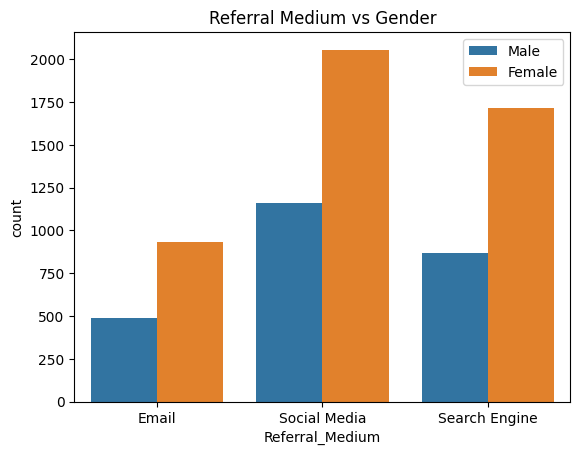

In [25]:
#Plotting a Chart of Referral Medium vs Gender
sns.countplot(x='Referral_Medium', hue='Gender', data=data)
plt.title('Referral Medium vs Gender')
plt.legend(loc='upper right')
plt.show()

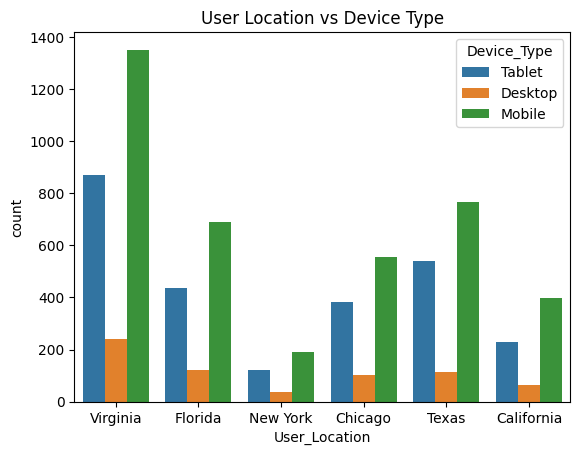

In [26]:
#Plotting a Chart of User Location vs Device Type
sns.countplot(x='User_Location', hue='Device_Type', data=data)
plt.title('User Location vs Device Type')
plt.show()

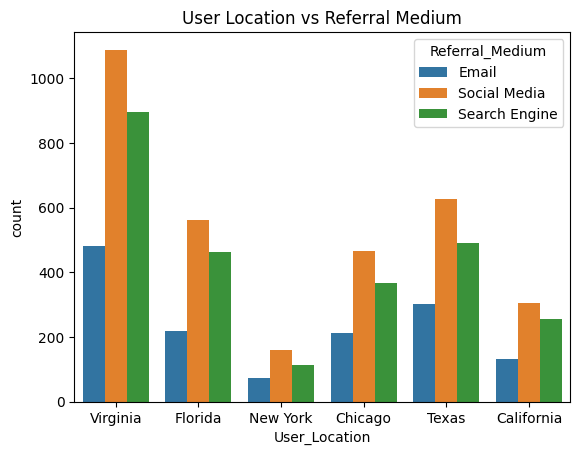

In [27]:
#Plotting a Chart of User Location vs Referral Medium
sns.countplot(x='User_Location', hue='Referral_Medium', data=data)
plt.title('User Location vs Referral Medium')
plt.show()

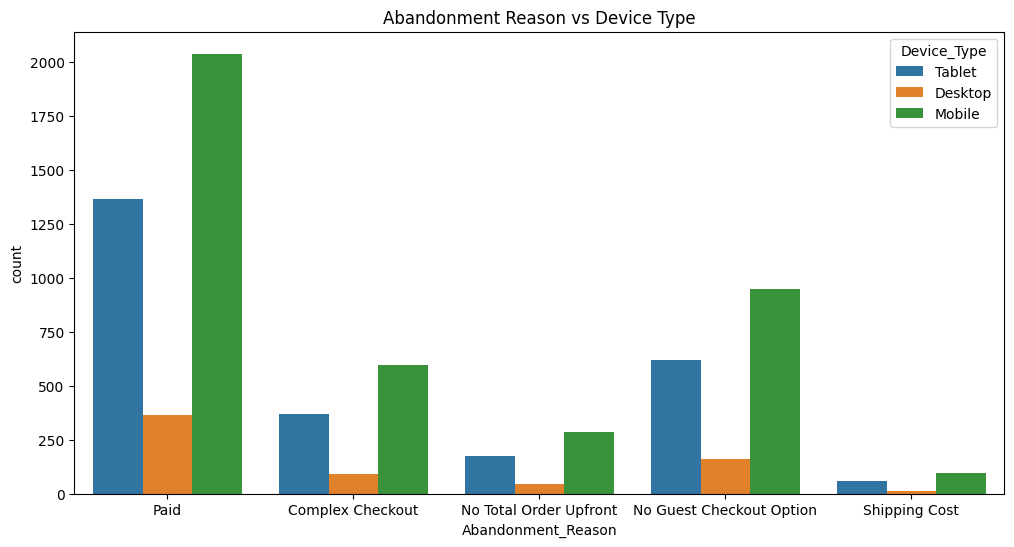

In [28]:
#Plotting a Chart of Abandonment Reason vs Device Type
plt.figure(figsize=(12, 6))
sns.countplot(x='Abandonment_Reason', hue='Device_Type', data=data)
plt.title('Abandonment Reason vs Device Type')
plt.show()

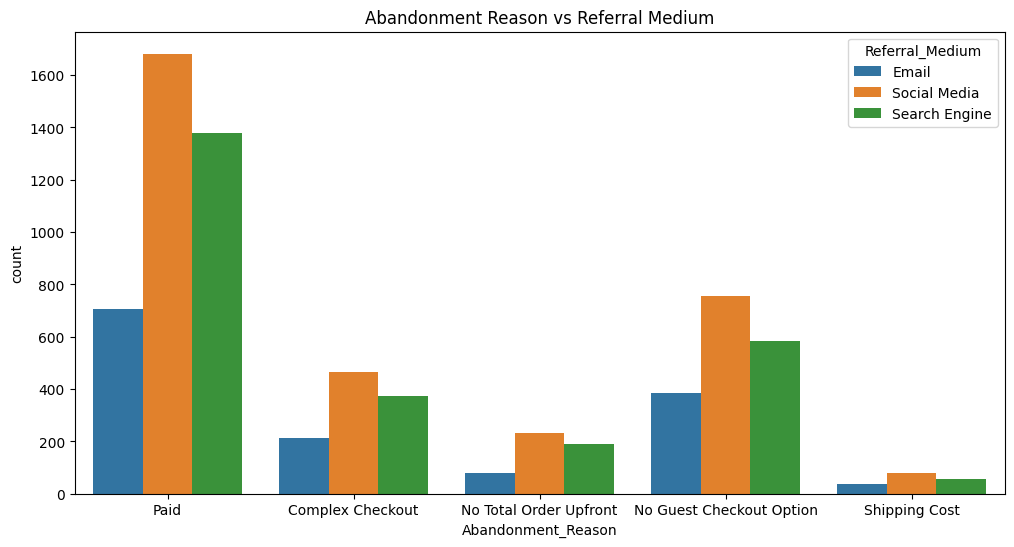

In [29]:
#Plotting a Chart of Abandonment Reason vs Referral Medium
plt.figure(figsize=(12, 6))
sns.countplot(x='Abandonment_Reason', hue='Referral_Medium', data=data)
plt.title('Abandonment Reason vs Referral Medium')
plt.show()

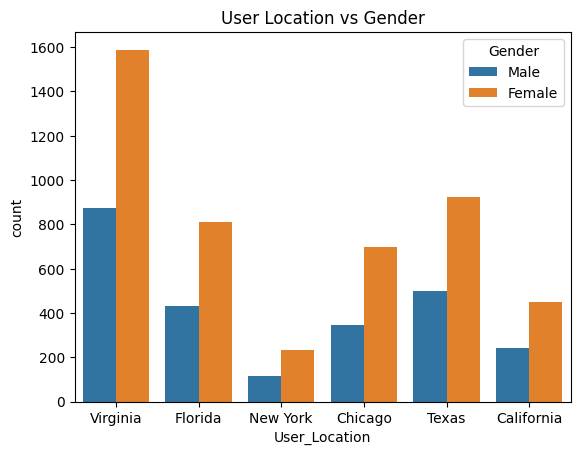

In [30]:
#Plotting a Chart of User Location vs Gender
sns.countplot(x='User_Location', hue='Gender', data=data)
plt.title('User Location vs Gender')
plt.show()

Key Performance Indicators

In [31]:
#Calculating the Number of Abandoned Carts and the Abandonment Rate
total_carts=len(data)
abandoned_carts=data[data['Cart_Status']=='Abandoned']
paid_carts=data[data['Cart_Status']=='Paid']
abandoned_percentage=(len(abandoned_carts)/total_carts)*100
paid_percentage=(len(paid_carts)/total_carts)*100

print('Total Carts:', total_carts)
print('Abandoned Carts:', len(abandoned_carts))
print(f'Abandonment Rate: {abandoned_percentage:.2f}%')

Total Carts: 7211
Abandoned Carts: 3447
Abandonment Rate: 47.80%


In [32]:
#Calculating Average Cart Value, Total Cart Value, Total Abandoned Cart Value
average_cart_value=data['Cart_Value'].mean()
average_abandoned_cart_value=abandoned_carts['Cart_Value'].mean()

total_cart_value=data['Cart_Value'].sum()
total_abandoned_cart_value=abandoned_carts['Cart_Value'].sum()

print(f'Average Cart Value: ${average_cart_value:.2f}')
print(f'Average Abandoned Cart Value: ${average_abandoned_cart_value:.2f}')
print(f'Total Cart Value: ${total_cart_value:.2f}')
print(f'Total Abandoned Cart Value: ${total_abandoned_cart_value:.2f}')

Average Cart Value: $258.36
Average Abandoned Cart Value: $257.03
Total Cart Value: $1863066.77
Total Abandoned Cart Value: $885968.01


In [33]:
#Calculating Average Session Duration
average_session_duration=data['Session_Duration'].mean()
print(f'Average Session Duration: {average_session_duration:.2f}')

Average Session Duration: 62.10


Data Preprocessing

In [34]:
data.head()

,User_ID,User_Location,Gender,Cart_Contents,Cart_Value,Session_Duration,Abandonment_Reason,Purchase_Category,Referral_Medium,Device_Type,Cart_Status,Day,Year,Month,Date,Week
0,User_1,Virginia,Male,Toys,152.01,99,Paid,Teddy bears,Email,Tablet,Paid,Sunday,2023,12,24,51
1,User_2,Florida,Male,Footwear,222.52,32,Paid,Oxfords,Social Media,Tablet,Paid,Tuesday,2023,10,3,40
2,User_3,New York,Male,Toys,331.94,62,Complex Checkout,Games,Social Media,Desktop,Abandoned,Sunday,2023,11,19,46
3,User_4,Virginia,Male,Toys,222.85,32,Paid,Dolls,Search Engine,Mobile,Paid,Saturday,2023,12,2,48
4,User_5,Chicago,Female,Home Decor,309.79,63,No Total Order Upfront,Vase,Social Media,Mobile,Abandoned,Wednesday,2023,8,2,31


In [35]:
data_copy = data.copy()
le=LabelEncoder()
for col in data_copy.columns:
  if data_copy[col].dtype=='object':
    data_copy[col]=le.fit_transform(data_copy[col])
correlations = data_copy.corr()['Cart_Status'].sort_values(ascending=False)
print(correlations)

Cart_Status           1.000000
Abandonment_Reason    0.838539
Referral_Medium       0.014407
Month                 0.011222
Week                  0.010764
Cart_Value            0.009264
Date                  0.002929
Device_Type           0.001650
Session_Duration      0.001562
Purchase_Category    -0.001744
Cart_Contents        -0.002943
User_Location        -0.004549
Day                  -0.005397
Gender               -0.013201
User_ID              -0.013341
Year                       NaN
Name: Cart_Status, dtype: float64


In [36]:
#Dividing the Data into Features and Target
features=data.drop(['User_ID', 'Cart_Status', 'Year', 'Abandonment_Reason', 'Date', 'Week'], axis=1)
target=data['Cart_Status']

In [37]:
features.shape, target.shape

((7211, 10), (7211,))

In [38]:
#Label Encoding
le=LabelEncoder()
features['Purchase_Category']=le.fit_transform(features['Purchase_Category'])
target=le.fit_transform(target)

In [39]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

encoded_features = []

for col in features.columns:
    if features[col].dtype == 'object':
        onehot = OneHotEncoder(drop='first', sparse_output=False)  # Set sparse_output to False
        reshaped = features[[col]]
        encoded = onehot.fit_transform(reshaped)
        # Get feature names directly from the OneHotEncoder
        feature_names = onehot.get_feature_names_out([col])
        encoded_df = pd.DataFrame(encoded, columns=feature_names)
        encoded_features.append(encoded_df)
    else:
        encoded_features.append(features[[col]])

# Concatenate everything back together
features_encoded = pd.concat(encoded_features, axis=1)

In [40]:
#Scaling the Data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_encoded)

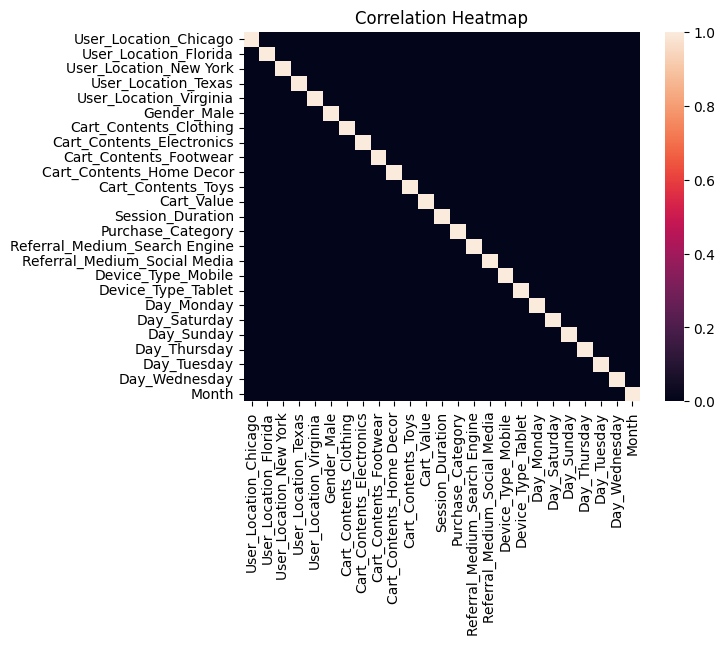

In [41]:
#Plotting a Heatmap to check Correlation
sns.heatmap(features_encoded.corr()>0.9)
plt.title('Correlation Heatmap')
plt.show()

In [42]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

Model Building & Evaluation

In [43]:
#Defining the Models
models={
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC(kernel='rbf'),
    'XGBoost': XGBClassifier()
}

#Calculating the Training and Testing Accuracy and the Classification Report
for name, model in models.items():
    model.fit(X_train, y_train) # Fit on scaled data
    print(name + ' trained.')
    train_pred = model.predict(X_train) # Predict on scaled data
    print('Trainig Accuracy: {:.2f}'.format(accuracy_score(y_train, train_pred)))
    test_pred = model.predict(X_test) # Predict on scaled data
    print('Testing Accuracy: {:.2f}\n'.format(accuracy_score(y_test, test_pred)))
    print('Classification Report:')
    print(classification_report(y_test, test_pred))
    print('='*50)

Random Forest trained.
Trainig Accuracy: 1.00
Testing Accuracy: 0.49

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.40      0.44       715
           1       0.49      0.58      0.53       728

    accuracy                           0.49      1443
   macro avg       0.49      0.49      0.48      1443
weighted avg       0.49      0.49      0.49      1443

Logistic Regression trained.
Trainig Accuracy: 0.53
Testing Accuracy: 0.50

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.20      0.28       715
           1       0.50      0.80      0.62       728

    accuracy                           0.50      1443
   macro avg       0.50      0.50      0.45      1443
weighted avg       0.50      0.50      0.45      1443

Support Vector Machine trained.
Trainig Accuracy: 0.67
Testing Accuracy: 0.49

Classification Report:
              precision    recall  f1-score   suppor

In [44]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# Initialize the classifier
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit to your training data
grid_search.fit(X_train, y_train)

# Show best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy on Validation:", grid_search.best_score_)

# Evaluate on test data
best_model = grid_search.best_estimator_
print("Test Accuracy:", best_model.score(X_test, y_test))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 50}
Best Accuracy on Validation: 0.5239234248385269
Test Accuracy: 0.49965349965349964


In [45]:
#Stratified K-Fold Cross Validation
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#For Random Forest
rf_scores=cross_val_score(RandomForestClassifier(), features_scaled, target, cv=cv)
print("Random Forest CV Accuracy:", rf_scores.mean())

#For Logistic Regression
log_reg_scores=cross_val_score(LogisticRegression(max_iter=1000), features_scaled, target, cv=cv)
print("Logistic Regression CV Accuracy:", log_reg_scores.mean())

#For SVM
svm_scores=cross_val_score(SVC(class_weight='balanced'), features_scaled, target, cv=cv)
print("SVM CV Accuracy:", svm_scores.mean())

#For XGBoost
xgb_scores=cross_val_score(XGBClassifier(), features_scaled, target, cv=cv)
print("XGBoost CV Accuracy:", xgb_scores.mean())

Random Forest CV Accuracy: 0.5025641025641026
Logistic Regression CV Accuracy: 0.5106088698321708
SVM CV Accuracy: 0.5139345042257664
XGBoost CV Accuracy: 0.512690851525803


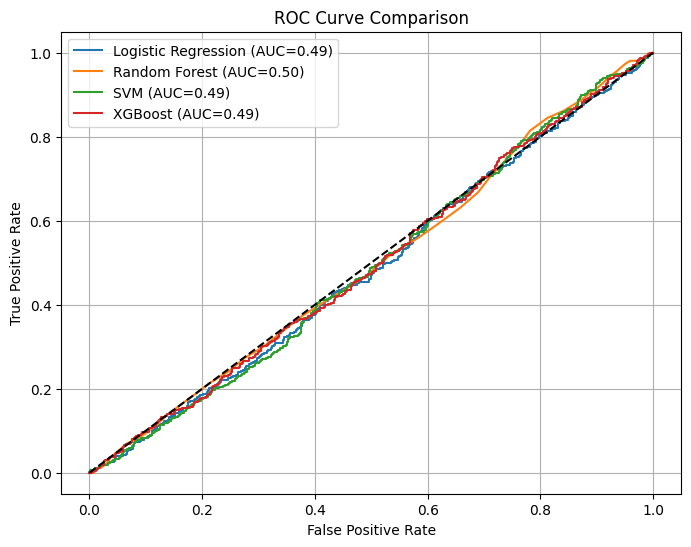

In [46]:
#Plotting the ROC Curve for all Models
models={
  "Logistic Regression": LogisticRegression(max_iter=1000),
  "Random Forest": RandomForestClassifier(),
  "SVM": SVC(probability=True, class_weight='balanced'),
  'XGBoost': XGBClassifier()
}

plt.figure(figsize=(8,6))
for name, model in models.items():
    model.fit(X_train, y_train)
    probs=model.predict_proba(X_test)[:,1]
    fpr, tpr, _=roc_curve(y_test, probs)
    auc_score=auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc_score:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

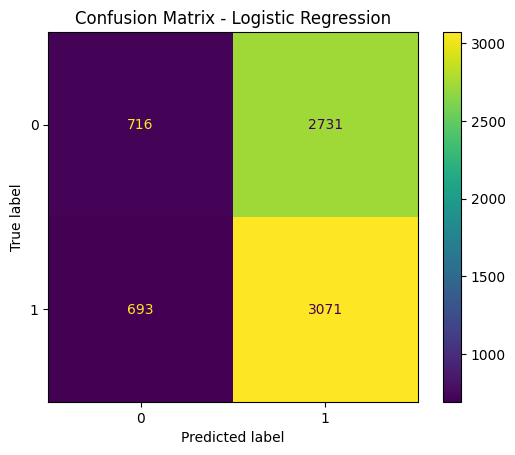

In [47]:
#Confusion Matrix for Logistic Regression
y_pred=models['Logistic Regression'].predict(features_scaled)
cm=confusion_matrix(target, y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

**Conclusion**

This analysis not only helps visualize e-commerce user behavior but also includes a basic machine learning model that attempts to predict whether a customer will abandon their cart.

While the current model achieves ~50% accuracy due to limitations in data quality and volume, it serves as a foundation. With more granular features, this model can be refined to drive real-time personalized offers and reduce revenue loss from cart abandonment.